In [1]:
import collections
import pandas
import matplotlib, seaborn, numpy
from matplotlib import pyplot
from numpy.testing import assert_equal

import bz2

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score

%matplotlib inline


In [2]:
df = pandas.read_csv("/Users/tim/Dropbox/sinai/projects/uri/201801-antibody-epitope-prediction/train.20171126.csv.bz2")
df = df.set_index("id")
df["sequence_start"] = df.index.map(lambda s: int(s.split("|")[2].split("-")[0]))
df["sequence_end"] = df.index.map(lambda s: int(s.split("|")[2].split("-")[1]))
df

,uniprot_accession,sequence_aa,num_sequences,max_uniprot,max_id,ratio,sequence_start,sequence_end
id,,,,,,,,
10000|D2XQA7|533-588,D2XQA7,GTSGFAELLHALHLDSLNLIPAINCSKITADKIIATVPLPHVTYII...,26,230.68,15.73,0.068190,533,588
10001|D2XQA7|561-616,D2XQA7,TADKIIATVPLPHVTYIISSEAISNAVVYEVSEIFLKSAMFISAIK...,26,230.68,7.73,0.033510,561,616
10002|D2XQA7|589-644,D2XQA7,YEVSEIFLKSAMFISAIKPDCSGFNFSQIDRHIPIVYNISTPRRGC...,26,230.68,14.08,0.061037,589,644
10003|D2XQA7|617-672,D2XQA7,IDRHIPIVYNISTPRRGCPLCDSVIMSYDESDGLQSLMYVTNERVQ...,26,230.68,7.39,0.032036,617,672
10004|D2XQA7|645-700,D2XQA7,DESDGLQSLMYVTNERVQTNLFLDKSPFFDNNNLHIHYLWLRDNGT...,26,230.68,22.33,0.096801,645,700
10005|D2XQA7|673-728,D2XQA7,FDNNNLHIHYLWLRDNGTVVEIRGMYRRRAASALFLILSFIGFSGV...,26,230.68,9.12,0.039535,673,728
10006|D2XQA7|701-730,D2XQA7,RAASALFLILSFIGFSGVIYFLYRLFSILY,26,230.68,12.28,0.053234,701,730
1000|A5I8J1|169-205,A5I8J1,DWKVCQRIVGLLGFAAPFTQCGYPALMPLYACIQAKQ,7,117.63,42.42,0.360622,169,205
10012|D2XQC4|1-56,D2XQC4,MRASKSDRFLMSSWVKLLFVAVIMYICSAVVPMAATYEGLGFPCYF...,14,414.12,7.99,0.019294,1,56


In [3]:
bepipred_df = pandas.read_table(
    "/Users/tim/Dropbox/sinai/projects/uri/201801-antibody-epitope-prediction/virscan_orfs.bepipred.txt.bz2",
    nrows=None,
    names=["Entry", "Pos", "AA", "RSA", "Helix", "Sheet", "Coil", "Pred", "Epitope"],
    comment="#",
    true_values="E",
    false_values=".",
)
bepipred_df

,Entry,Pos,AA,RSA,Helix,Sheet,Coil,Pred,Epitope
0,P17149,1,M,0.575,0.003,0.003,0.994,0.15000,False
1,P17149,2,T,0.262,0.003,0.718,0.279,0.17567,False
2,P17149,3,L,0.133,0.001,0.959,0.040,0.19800,False
3,P17149,4,V,0.044,0.001,0.959,0.040,0.23456,False
4,P17149,5,L,0.036,0.001,0.959,0.040,0.28456,False
5,P17149,6,F,0.046,0.001,0.959,0.040,0.30967,False
6,P17149,7,A,0.025,0.002,0.816,0.182,0.32589,False
7,P17149,8,T,0.058,0.004,0.514,0.481,0.33833,False
8,P17149,9,E,0.279,0.020,0.205,0.775,0.35844,False
9,P17149,10,Y,0.224,0.116,0.016,0.868,0.38711,False


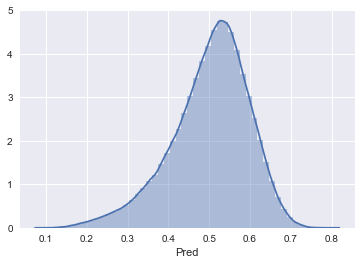

In [4]:
seaborn.distplot(bepipred_df.Pred)

In [5]:
bepipred_df.Entry.nunique(), df.uniprot_accession.nunique()

(8824, 5845)

In [6]:
bepipred_dict = {}
for (entry, sub_df) in bepipred_df.groupby("Entry"):
    bepipred_dict[entry] = sub_df.set_index("Pos")
len(bepipred_dict)

8824

In [7]:
bepipred_dict[df.iloc[0].uniprot_accession].loc[10: 30]

,Entry,AA,RSA,Helix,Sheet,Coil,Pred,Epitope
Pos,,,,,,,,
10,D2XQA7,L,0.114,0.938,0.007,0.055,0.29611,False
11,D2XQA7,A,0.169,0.938,0.007,0.055,0.30367,False
12,D2XQA7,C,0.077,0.878,0.010,0.111,0.32400,False
13,D2XQA7,W,0.102,0.802,0.014,0.185,0.35756,False
14,D2XQA7,R,0.327,0.802,0.014,0.185,0.40067,False
15,D2XQA7,C,0.114,0.802,0.014,0.185,0.43133,False
16,D2XQA7,I,0.118,0.717,0.014,0.269,0.46144,False
17,D2XQA7,S,0.451,0.660,0.049,0.291,0.49500,False
18,D2XQA7,L,0.299,0.455,0.046,0.498,0.50922,True


In [8]:
bepipred_dict[df.iloc[0].uniprot_accession].loc[10: 30].Pred.ewm(com=5).mean()




Pos
10    0.296110
11    0.300234
12    0.309636
13    0.325063
14    0.346131
15    0.367481
16    0.389203
17    0.412179
18    0.432241
19    0.450899
20    0.468700
21    0.484900
22    0.498768
23    0.510298
24    0.516820
25    0.521413
26    0.525317
27    0.529708
28    0.532377
29    0.535831
30    0.540005
Name: Pred, dtype: float64

In [9]:
bepipred_dict[df.iloc[0].uniprot_accession].loc[10: 20].Pred.ewm

<bound method NDFrame._add_series_or_dataframe_operations.<locals>.ewm of Pos
10    0.29611
11    0.30367
12    0.32400
13    0.35756
14    0.40067
15    0.43133
16    0.46144
17    0.49500
18    0.50922
19    0.52611
20    0.54333
Name: Pred, dtype: float64>

In [13]:
def make_bepipred_predictions(uniprot_accession, sequence_start, sequence_end, sequence_aa, **kwargs):
    try:
        sub_df = bepipred_dict[uniprot_accession].loc[sequence_start : sequence_end]
    except KeyError:
        return None
    if list(sequence_aa) != list(sub_df.AA):
        return None
    return {
        'max': sub_df.Pred.max(),
        'mean': sub_df.Pred.mean(),
        'count>0.5': (sub_df.Pred > 0.5).sum(),
        'ewm max, com=5': sub_df.Pred.ewm(com=5).mean().max(),
    }

bepipred_predictions = []
for (i, (_, row)) in enumerate(df.iterrows()):
    if i % 10000 == 0:
        print("%05d / %05d" % (i + 1, len(df)))
    bepipred_predictions.append(make_bepipred_predictions(**row.to_dict()))

df["bepipred"] = bepipred_predictions
df["binary_label"] = df.ratio > 0.5

print("No predictions for %0.5f%%" % df.bepipred.map(lambda x: x is None).mean())

usable_df = df.loc[df.bepipred.map(lambda x: x is not None)].copy()
bepipred_keys = usable_df.iloc[0].bepipred.keys()
for key in bepipred_keys:
    usable_df[key] = usable_df.bepipred.map(lambda x: x[key])
usable_df

scores = collections.OrderedDict()
for key in bepipred_keys:
    scores["Bepipred %s" % key] = (
        [roc_auc_score(usable_df.binary_label.values, usable_df[key].values)], key )
scores

00001 / 83664
10001 / 83664
20001 / 83664
30001 / 83664
40001 / 83664
50001 / 83664
60001 / 83664
70001 / 83664
80001 / 83664
No predictions for 0.00400%


OrderedDict([('Bepipred mean', ([0.69240562505540315], 'mean')),
             ('Bepipred max', ([0.63540672565373968], 'max')),
             ('Bepipred count>0.5', ([0.65150974002090256], 'count>0.5')),
             ('Bepipred ewm max, com=5',
              ([0.64508849856719974], 'ewm max, com=5'))])

In [15]:
cross_val_score_args = {'cv': 5, 'n_jobs': -1, "scoring": "roc_auc", "groups": usable_df.uniprot_accession.values}

pipeline = Pipeline([
    ('vect', CountVectorizer(analyzer="char", ngram_range=(1, 1))),
    ('clf', LogisticRegression()),
])
score = cross_val_score(
    pipeline,
    usable_df.sequence_aa.values,
    usable_df.binary_label,
    **cross_val_score_args)
scores["LogisticRegression kmers=1"] = (score, pipeline)
score

array([ 0.76371074,  0.77650078,  0.77148693,  0.74034193,  0.76906858])

/Users/tim/miniconda3/envs/py3k/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


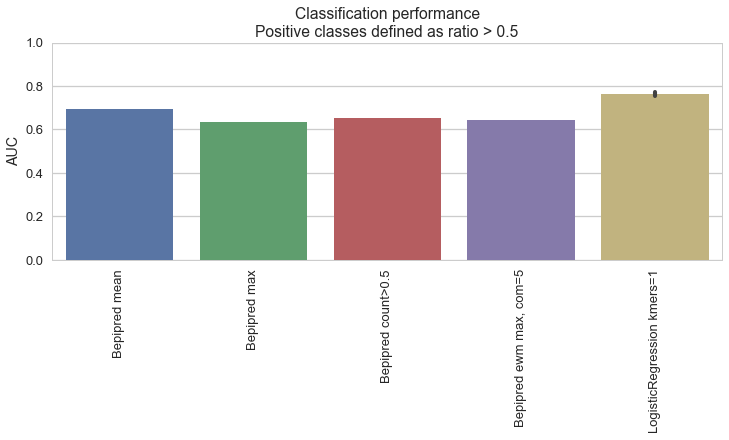

In [18]:
scores_rows = []
for (label, (values, pipeline)) in scores.items():
    for v in values:
        scores_rows.append([label, v, pipeline])

scores_df = pandas.DataFrame(scores_rows, columns=["label", "value", "pipeline"])
scores_df

pyplot.figure(figsize=(12,4))
seaborn.set_context('talk')
seaborn.set_style('whitegrid')
seaborn.barplot(x="label", y="value", data=scores_df)
pyplot.ylim(ymin=0, ymax=1)
pyplot.xticks(rotation=90)
pyplot.xlabel("")
pyplot.ylabel("AUC")
pyplot.title("Classification performance\nPositive classes defined as ratio > 0.5")